# Imported Libraries

In [1]:

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, LSTM, Input, Reshape 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import os



# Image Dataset Import

In [2]:
labels = ['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
img_size = 224
def get_data(data_dir):
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                crop_image= img_arr[0:1728,430:2190]
                resized_arr = cv2.resize(crop_image, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
#function call to get_data function that takes file path of the dataset.
data= get_data('dataset/all_equal_300_images/')

<ipython-input-2-b08f5e223f84>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [4]:
data.shape

(1200, 2)

In [5]:
type(data)

numpy.ndarray

# Dividing Data Ndarray into Normal, Cataract, Glaucoma and Retina diseases. 

In [6]:
normal= data[0:300]
normal.shape

(300, 2)

In [7]:
cataract=data[300:600]
cataract.shape

(300, 2)

In [8]:
glaucoma= data[600:900]
glaucoma.shape

(300, 2)

In [9]:
retina_disease= data[900:1200]
retina_disease.shape

(300, 2)

In [10]:
random.seed(15)
np.random.shuffle(normal)
np.random.shuffle(cataract)   
np.random.shuffle(glaucoma)
np.random.shuffle(retina_disease)

# Performing Normalization and Resize operation 

In [11]:
def normalize(x_train,x_val,x_test): 
    
    x_train = np.array(x_train) / 255
    x_train.reshape(-1, img_size, img_size, 1)
    
    x_test= np.array(x_test) / 255
    x_test.reshape(-1, img_size, img_size, 1)
    
    x_val= np.array(x_val) / 255
    x_val.reshape(-1, img_size, img_size, 1) 
        
    return (x_train,x_val,x_test) 


# Separating the Images and Labels into Respective Variables

In [12]:
def image_label_split(train,validation,test):
    
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    for feature, label in train:
      x_train.append(feature)
      y_train.append(label)

    for feature, label in validation:
      x_val.append(feature)
      y_val.append(label)


    for feature, label in test:
      x_test.append(feature)
      y_test.append(label)

        
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test= np.array(y_test)
    
    return (x_train,y_train,x_val,y_val,x_test,y_test)


# InceptionV3-LSTM MODEL

In [13]:
def model_build_compile(k): 
    baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
            layer.trainable = False

    x = baseModel.output

        # LSTM layer
    x = Reshape((25, 2048))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)     

        # FC layer
    x = Flatten(name="flatten")(x)

        # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
        
        # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)         

        # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=baseModel.input, outputs=output)
    opt = RMSprop(learning_rate=0.01, clipvalue=100)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    k=k+1
    print("model building and compiling for fold",k)
    return model

# Model prediction for Test Images and Computation of Sensitivity and Specificity

In [14]:
def test_pred(x_val,y_val,k):
    predictions = model.predict(x_val)
    predictions = np.argmax(predictions, axis = -1)
    
    print('----------------Test accuracy for',k+1,'fold----------------')
    #Confusion matrix, Accuracy, sensitivity and specificity
    cm1 = confusion_matrix(y_val,predictions)
    print('Confusion Matrix : \n', cm1)


    #####from confusion matrix calculate accuracy
        
    sensitivity_1_normal = (cm1[0,0])/(cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (cm1[1,1])/(cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (cm1[2,2])/(cm1[2,0]+cm1[2,1]+cm1[2,2]+cm1[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (cm1[3,3])/(cm1[3,0]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])/(cm1[1,0]+cm1[2,0]+cm1[3,0]+cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])/(cm1[0,1]+cm1[2,1]+cm1[3,1]+cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])/(cm1[0,2]+cm1[1,2]+cm1[3,2]+cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])/(cm1[0,3]+cm1[1,3]+cm1[2,3]+cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    
    total1=sum(sum(cm1))
    test_accuracy=(cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)
    print('-----------------------------End of',k+1,'Fold--------------------------')
    return test_accuracy,Specificity,Sensitivity,cm1


In [15]:
CM= []
test_accuracy=[]
test_sensitivity=[]
test_specificity=[]
train_acc = []
val_acc = []
train_loss = []
val_loss = []

# InceptionV3-LSTM 5 Fold Cross Validation

In [16]:
for k in range (5): # for loop to run 5 folds 
    n=30  #specifying the number of images for each class in test phase,calulated as per 10% of total images in each class images 300.
    
    
    # Adding the images in normal validation set by using k*n to (k+1)*n as index values for normal dataset divided in cell 6.
    test_normal= normal[k*n:(k+1)*n]
    print('------------------------Start of',k+1,'Fold------------------------')
    print('test images for normal class from',k*n,(k+1)*n)
    
    # Adding the images in cataract validation set by using k*n to (k+1)*nas index values for cataract dataset divided in cell 7.
    test_cataract= cataract[k*n:(k+1)*n]
    print('test images for cataract class from',k*n,(k+1)*n)
    
    # Adding the images in gluacoma validation set by using k*nto (k+1)*n as index values for gluacoma dataset divided in cell 8.
    test_glaucoma= glaucoma[k*n:(k+1)*n]
    print('test images for glaucoma class from',k*n,(k+1)*n)
    
    # Adding the images in retina disease validation set by using k*n to (k+1)*n as index values for retina disease dataset divided in cell 9.
    test_retina= retina_disease[k*n:(k+1)*n]
    print('test images for retina disease class from',k*n,(k+1)*n)
    
    # Now for train and validation set of Normal images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 
    
    train_validation_normal= normal[:k*n] 
    train_validation_normal= np.append(train_validation_normal,normal[(k+1)*n:],axis=0)
    print('train_validation images for normal class from 0 to',k*n,'and',(k+1)*n,'to 300')
    
    # Now for train and validation set of cataract images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 
    
    train_validation_cataract= cataract[:k*n] 
    train_validation_cataract= np.append(train_validation_cataract,cataract[(k+1)*n:],axis=0)
    print('train_validation images for cataract class from 0 to',k*n,'and',(k+1)*n,'to 300')

    # Now for train and validation set of glaucoma images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 

    train_validation_glaucoma= glaucoma[:k*n] 
    train_validation_glaucoma= np.append(train_validation_glaucoma,glaucoma[(k+1)*n:],axis=0)
    print('train_validation  images for glaucoma class from 0',k*n,'and',(k+1)*n,'to 300')
    
    # Now for train and validation set of retina disease images first adding 0 to k*n images and then adding all the images from (k+1)*n till last image. 

    train_validation_retina= retina_disease[:k*n] 
    train_validation_retina= np.append(train_validation_retina,retina_disease[(k+1)*n:],axis=0)
    print('train_validation images for retina disease class from 0 to',k*n,'and',(k+1)*n,'to 300')
    
      
    # Splitting the train validation datasets in 80:20 ratio which would eventually give us 70% images in train and 20% images in validation and 10% in test.

    normal_train, normal_validation                 = train_test_split(train_validation_normal, test_size=0.20, random_state=14,shuffle=True)
    cataract_train, cataract_validation             = train_test_split(train_validation_cataract, test_size=0.20, random_state=14,shuffle=True)
    glaucoma_train, glaucoma_validation             = train_test_split(train_validation_glaucoma, test_size=0.20, random_state=14,shuffle=True)
    retina_disease_train, retina_disease_validation = train_test_split(train_validation_retina, test_size=0.20, random_state=14,shuffle=True)

    # Appending all train set images for all classes
    train= np.append(normal_train,cataract_train,axis=0)
    train= np.append(train,glaucoma_train,axis=0)
    train= np.append(train,retina_disease_train,axis=0)

    # Appending all validation set images for all classes
    validation= np.append(normal_validation,cataract_validation,axis=0)
    validation= np.append(validation,glaucoma_validation,axis=0)
    validation= np.append(validation,retina_disease_validation,axis=0)
    
    # Appending all test set images for all classes
    test= np.append(test_normal,test_cataract,axis=0)
    test= np.append(test,test_glaucoma,axis=0)
    test= np.append(test,test_retina,axis=0)    
    

    # Shuffling the train validation and test set as they are added sequentially. 
    random.seed(6)
    np.random.shuffle(train)
    np.random.shuffle(validation)   
    np.random.shuffle(test)
 
    
    # Passing the train validation test as argument for image_label_split function that return features and labels separated.
    x_train,y_train,x_val,y_val,x_test,y_test = image_label_split(train,validation,test)
    
    # Passing the x_Train x_val and x_test as a argument for normalize function that returns the normalized and reshaped sets.
    x_train,x_val,x_test = normalize(x_train,x_val,x_test)
    
    # model building and model compile is done using a model_build_compile().
    model = model_build_compile(k)
    history = model.fit(x_train,y_train,epochs =50, validation_data = (x_val,y_val))
    

    train_acc = np.append(train_acc,history.history['accuracy'])
    val_acc = np.append(val_acc,history.history['val_accuracy'])
    
    train_loss = np.append(train_loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
                        
    x,y,z,c = test_pred(x_test,y_test,k)
    

    CM.append([c])
    test_accuracy.append(x)
    test_specificity.append(y)
    test_sensitivity.append(z)
  

------------------------Start of 1 Fold------------------------
test images for normal class from 0 30
test images for cataract class from 0 30
test images for glaucoma class from 0 30
test images for retina disease class from 0 30
train_validation images for normal class from 0 to 0 and 30 to 300
train_validation images for cataract class from 0 to 0 and 30 to 300
train_validation  images for glaucoma class from 0 0 and 30 to 300
train_validation images for retina disease class from 0 to 0 and 30 to 300
model building and compiling for fold 1
Epoch 1/50
27/27 [==============================] - 65s 2s/step - loss: 12.0051 - accuracy: 0.4248 - val_loss: 23.2962 - val_accuracy: 0.4398
Epoch 2/50
27/27 [==============================] - 61s 2s/step - loss: 4.9984 - accuracy: 0.5359 - val_loss: 27.8919 - val_accuracy: 0.2778
Epoch 3/50
27/27 [==============================] - 61s 2s/step - loss: 3.0320 - accuracy: 0.5903 - val_loss: 4.1650 - val_accuracy: 0.4259
Epoch 4/50
27/27 [=========

model building and compiling for fold 2
Epoch 1/50
27/27 [==============================] - 71s 2s/step - loss: 10.8944 - accuracy: 0.4549 - val_loss: 20.9369 - val_accuracy: 0.3750
Epoch 2/50
27/27 [==============================] - 66s 2s/step - loss: 4.1804 - accuracy: 0.5301 - val_loss: 6.2438 - val_accuracy: 0.4028
Epoch 3/50
27/27 [==============================] - 66s 2s/step - loss: 2.8937 - accuracy: 0.5556 - val_loss: 7.3541 - val_accuracy: 0.3843
Epoch 4/50
27/27 [==============================] - 68s 3s/step - loss: 2.7055 - accuracy: 0.6262 - val_loss: 5.5191 - val_accuracy: 0.3889
Epoch 5/50
27/27 [==============================] - 67s 2s/step - loss: 1.7363 - accuracy: 0.7060 - val_loss: 4.0092 - val_accuracy: 0.3935
Epoch 6/50
27/27 [==============================] - 67s 2s/step - loss: 1.7728 - accuracy: 0.7419 - val_loss: 2.4735 - val_accuracy: 0.5000
Epoch 7/50
27/27 [==============================] - 67s 2s/step - loss: 0.9248 - accuracy: 0.8148 - val_loss: 4.5899 -

27/27 [==============================] - 58s 2s/step - loss: 1.9835 - accuracy: 0.6030 - val_loss: 3.9956 - val_accuracy: 0.4259
Epoch 5/50
27/27 [==============================] - 60s 2s/step - loss: 1.8281 - accuracy: 0.7095 - val_loss: 3.1051 - val_accuracy: 0.4120
Epoch 6/50
27/27 [==============================] - 62s 2s/step - loss: 1.0048 - accuracy: 0.7975 - val_loss: 5.6232 - val_accuracy: 0.4167
Epoch 7/50
27/27 [==============================] - 59s 2s/step - loss: 1.1228 - accuracy: 0.7801 - val_loss: 5.5192 - val_accuracy: 0.4537
Epoch 8/50
27/27 [==============================] - 57s 2s/step - loss: 0.6687 - accuracy: 0.8519 - val_loss: 5.2839 - val_accuracy: 0.4722
Epoch 9/50
27/27 [==============================] - 58s 2s/step - loss: 0.5905 - accuracy: 0.8738 - val_loss: 7.3839 - val_accuracy: 0.4074
Epoch 10/50
27/27 [==============================] - 59s 2s/step - loss: 0.5649 - accuracy: 0.8993 - val_loss: 3.8225 - val_accuracy: 0.5463
Epoch 11/50
27/27 [===========

27/27 [==============================] - 64s 2s/step - loss: 1.0072 - accuracy: 0.7685 - val_loss: 4.9058 - val_accuracy: 0.4583
Epoch 7/50
27/27 [==============================] - 64s 2s/step - loss: 0.8840 - accuracy: 0.8252 - val_loss: 4.3706 - val_accuracy: 0.5093
Epoch 8/50
27/27 [==============================] - 64s 2s/step - loss: 0.8426 - accuracy: 0.8113 - val_loss: 4.5722 - val_accuracy: 0.4954
Epoch 9/50
27/27 [==============================] - 65s 2s/step - loss: 0.4337 - accuracy: 0.8866 - val_loss: 4.8491 - val_accuracy: 0.5185
Epoch 10/50
27/27 [==============================] - 65s 2s/step - loss: 0.2784 - accuracy: 0.9259 - val_loss: 3.6971 - val_accuracy: 0.5185
Epoch 11/50
27/27 [==============================] - 64s 2s/step - loss: 0.3461 - accuracy: 0.9120 - val_loss: 5.4818 - val_accuracy: 0.4861
Epoch 12/50
27/27 [==============================] - 64s 2s/step - loss: 0.2475 - accuracy: 0.9294 - val_loss: 2.7369 - val_accuracy: 0.6065
Epoch 13/50
27/27 [=========

# Test Evaluation Results

In [17]:
test_accuracy

[0.7166666666666667, 0.5833333333333334, 0.65, 0.55, 0.7166666666666667]

In [18]:
mean_test_accuracy=np.mean(test_accuracy)
mean_test_accuracy

0.6433333333333333

In [19]:
test_sensitivity

[0.7166666666666666,
 0.5833333333333334,
 0.6499999999999999,
 0.55,
 0.7166666666666666]

In [20]:
mean_test_sensitivity= np.mean(test_sensitivity)
mean_test_sensitivity

0.6433333333333333

In [21]:
test_specificity

[0.8853439457869838,
 0.8163277220839988,
 0.8542775936843734,
 0.8105912022732087,
 0.8854195270785659]

In [22]:
mean_test_specificity= np.mean(test_specificity)
mean_test_specificity

0.850391998181426

# Training and Validation Evaluation Results

In [23]:
train_acc

array([0.42476851, 0.53587961, 0.59027779, 0.63425928, 0.72222221,
       0.7511574 , 0.79050928, 0.86805558, 0.8738426 , 0.89583331,
       0.91087961, 0.94791669, 0.92476851, 0.93981481, 0.9548611 ,
       0.94675928, 0.95833331, 0.95023149, 0.9675926 , 0.95949072,
       0.9826389 , 0.97106481, 0.9675926 , 0.9699074 , 0.96296299,
       0.97453701, 0.97106481, 0.97916669, 0.97800928, 0.97685188,
       0.97453701, 0.98726851, 0.97916669, 0.9826389 , 0.97453701,
       0.99652779, 0.97106481, 0.98148149, 0.98032409, 0.9861111 ,
       0.9861111 , 0.98958331, 0.99074072, 0.99305558, 0.98958331,
       0.99768519, 0.9837963 , 0.99537039, 0.99537039, 0.99305558,
       0.4548611 , 0.5300926 , 0.55555558, 0.6261574 , 0.70601851,
       0.74189812, 0.81481481, 0.82175928, 0.84837961, 0.91203701,
       0.89583331, 0.91319442, 0.94444442, 0.94328701, 0.92939812,
       0.96296299, 0.93518519, 0.95601851, 0.94560188, 0.95833331,
       0.96180558, 0.96412039, 0.97222221, 0.97916669, 0.98263

In [24]:
mean_train_accuracy=np.mean(train_acc)
mean_train_accuracy

0.9191481482982635

In [25]:
val_acc

array([0.43981481, 0.27777779, 0.42592594, 0.43981481, 0.41666666,
       0.50925928, 0.47685185, 0.49074075, 0.61574072, 0.44444445,
       0.56481481, 0.56481481, 0.61574072, 0.47685185, 0.56018519,
       0.65277779, 0.67592591, 0.56481481, 0.70833331, 0.71296299,
       0.60648149, 0.6574074 , 0.70833331, 0.60648149, 0.68518519,
       0.64814812, 0.65277779, 0.63425928, 0.68055558, 0.64351851,
       0.67592591, 0.64814812, 0.58796299, 0.6712963 , 0.51851851,
       0.57407409, 0.52777779, 0.60648149, 0.67592591, 0.61574072,
       0.625     , 0.7175926 , 0.6388889 , 0.62962961, 0.625     ,
       0.66666669, 0.6111111 , 0.6111111 , 0.7037037 , 0.6388889 ,
       0.375     , 0.40277779, 0.38425925, 0.3888889 , 0.39351851,
       0.5       , 0.37037036, 0.56481481, 0.64814812, 0.58333331,
       0.58333331, 0.64351851, 0.64814812, 0.5324074 , 0.5787037 ,
       0.63425928, 0.68055558, 0.4861111 , 0.6574074 , 0.63425928,
       0.68055558, 0.6388889 , 0.6574074 , 0.6388889 , 0.67129

In [26]:
mean_val_accuracy=np.mean(val_acc)
mean_val_accuracy

0.6060555557012558

In [27]:
train_loss

array([1.20050745e+01, 4.99842167e+00, 3.03196573e+00, 1.95022953e+00,
       1.45973837e+00, 1.19738531e+00, 9.09744740e-01, 5.29269457e-01,
       5.55100858e-01, 3.64862055e-01, 4.68422472e-01, 1.80928335e-01,
       3.52628738e-01, 2.47118860e-01, 1.60193622e-01, 1.52577817e-01,
       1.55171961e-01, 2.07757786e-01, 1.52180448e-01, 1.17059521e-01,
       1.41288936e-01, 1.29641652e-01, 1.63623840e-01, 1.76264375e-01,
       2.04210728e-01, 9.15273279e-02, 1.18266404e-01, 7.48287737e-02,
       1.02338403e-01, 9.35271755e-02, 1.09549321e-01, 4.65884507e-02,
       1.21620178e-01, 4.79595810e-02, 1.36431932e-01, 1.14157014e-02,
       1.03143081e-01, 7.76456892e-02, 8.56947079e-02, 4.47275229e-02,
       4.50196788e-02, 5.01108468e-02, 3.01945675e-02, 3.15459333e-02,
       3.26646529e-02, 7.87159614e-03, 7.81944171e-02, 1.86193604e-02,
       1.78637486e-02, 3.94263491e-02, 1.08943624e+01, 4.18041563e+00,
       2.89367938e+00, 2.70554519e+00, 1.73627651e+00, 1.77275443e+00,
      

In [28]:
mean_train_loss= np.mean(train_loss)
mean_train_loss

0.6597210306767374

In [29]:
val_loss

array([ 23.29616928,  27.89188194,   4.16496325,   3.96786547,
         4.70674562,   4.81713963,   3.04645038,   3.27373409,
         2.99400187,   4.65174818,   4.98810673,   4.96675396,
         5.45057058,   6.29308176,   4.62964725,   4.48814726,
         4.87071133,   6.36779213,   2.53485227,   4.07831621,
         4.50777197,   4.34347486,   3.30170226,   5.75928164,
         3.2316494 ,   4.68473434,   3.57436562,   4.32099915,
         4.70328617,   4.23464584,   4.22507048,   3.7704854 ,
         5.93859339,   3.39202285,   7.47074366,   4.98230267,
         6.74173212,   5.51354694,   4.00906706,   6.52734089,
         7.25287247,   3.91458225,   4.54965258,   5.91009855,
         6.11809301,   4.55641603,   7.41960764,   6.53773499,
         4.92791176,  18.58941269,  20.93690109,   6.24384737,
         7.35406303,   5.51905394,   4.00919771,   2.47350907,
         4.58988237,   3.38239455,   2.92489743,   3.05239701,
         4.80225563,   3.3315289 ,   3.17443037,   6.96

In [30]:
mean_val_loss=np.mean(val_loss)
mean_val_loss

11.595856408119202

# Plot to Visualize the Number of Images in Each Label of Trainig Dataset

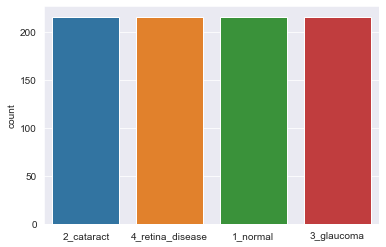

In [31]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Test Dataset.

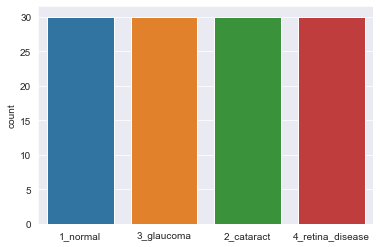

In [32]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Validation Dataset.

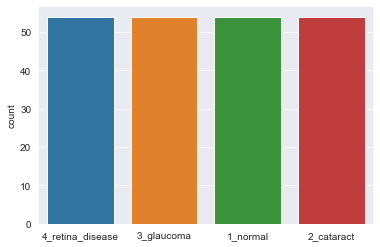

In [33]:
l = []
for i in validation:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Training,Validation Accuracy and Loss Plot for 50 Epochs

In [34]:
def plot_print(i,j):
    epochs_range = range(50)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_acc[i:j], label='Training Accuracy')
    plt.plot(epochs_range, val_acc[i:j], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_loss[i:j], label='Training Loss')
    plt.plot(epochs_range, val_loss[i:j], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    return plt.show()

Plot for  1 cross validation accuracy and loss for Training and Validation phase


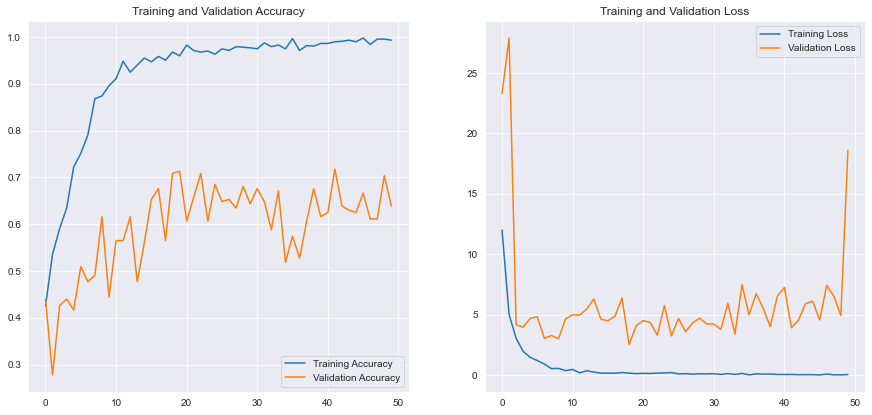

Plot for  2 cross validation accuracy and loss for Training and Validation phase


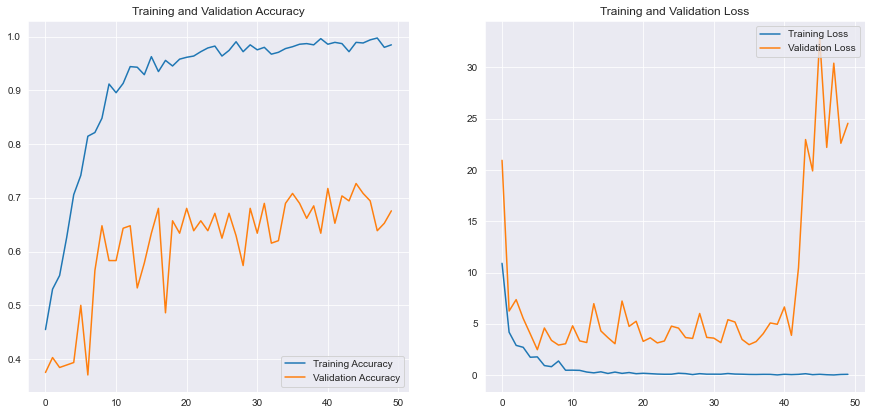

Plot for  3 cross validation accuracy and loss for Training and Validation phase


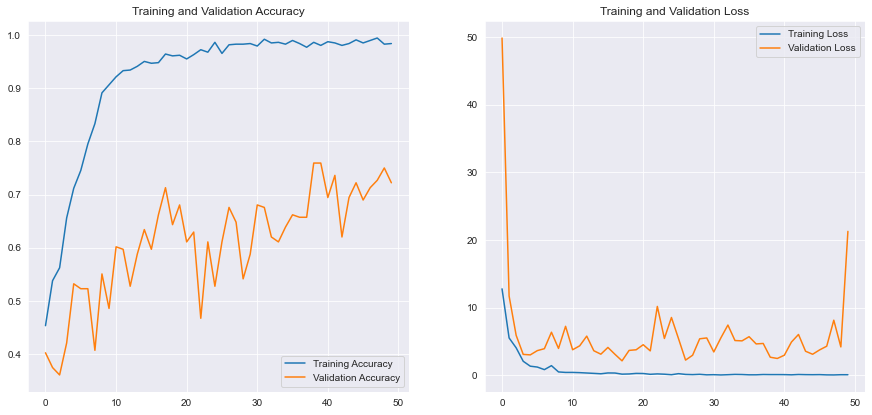

Plot for  4 cross validation accuracy and loss for Training and Validation phase


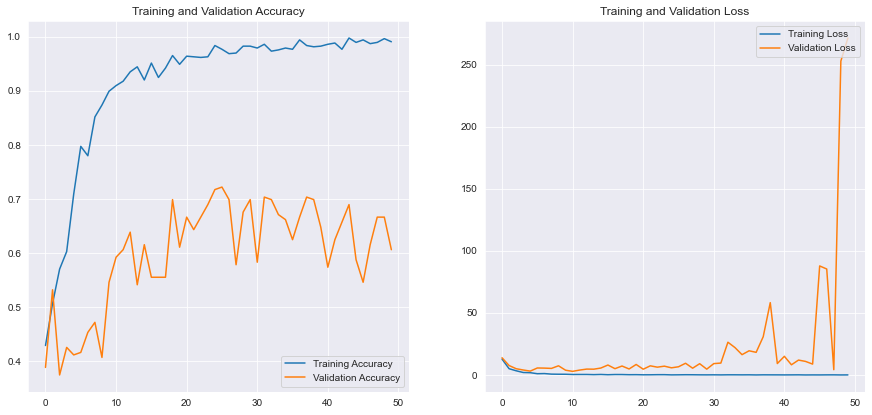

Plot for  5 cross validation accuracy and loss for Training and Validation phase


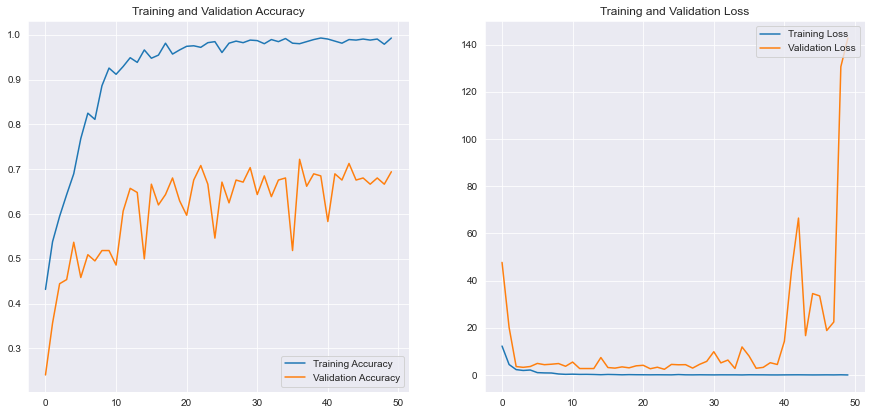

In [35]:
k=1
j=0
for i in range(0,250,50):
    j +=50
    print('Plot for ',k,'cross validation accuracy and loss for Training and Validation phase')
    k +=1
    plot_print(i,j)


# Visualizing Confusion Matrix for Each Fold

In [36]:
CM= np.array(CM)
CM.resize(5,4,4)

In [37]:
def confusionmatrix_vis(i):

        yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        plt.figure(figsize=(8, 8))
        hm =sns.heatmap(CM[i], annot=True,annot_kws={"size": 20}, cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

        hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
        hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

        plt.ylabel("Actual", fontsize = 18)
        plt.xlabel("Predicted",fontsize = 18)
      
        return plt.show()

Confusion Matrix for  1 Cross Validation Test phase


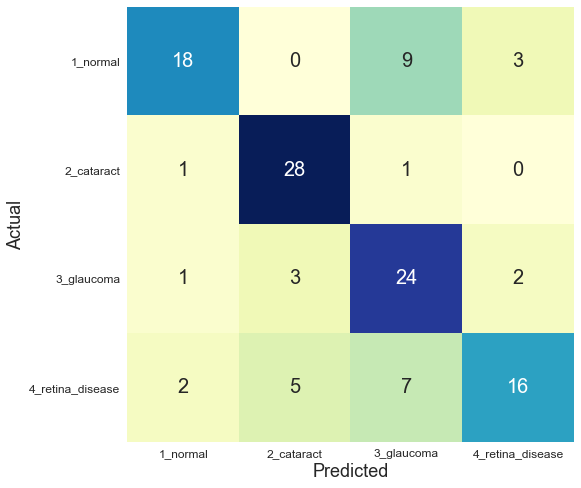

Confusion Matrix for  2 Cross Validation Test phase


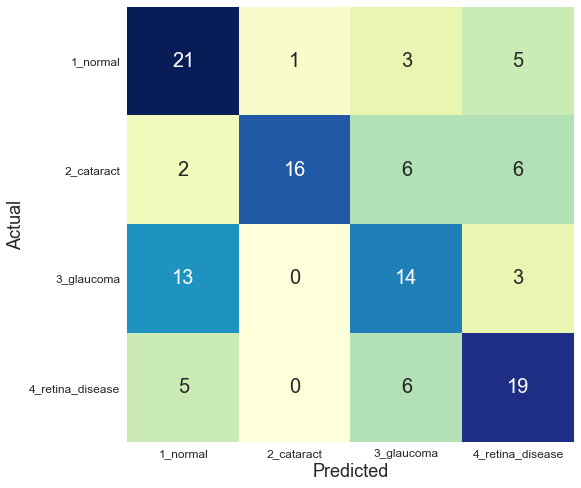

Confusion Matrix for  3 Cross Validation Test phase


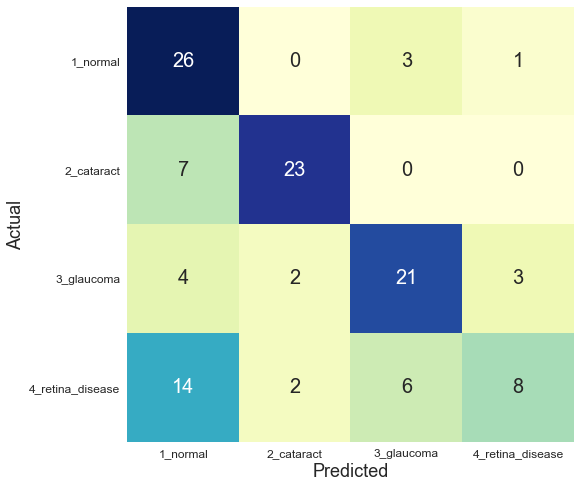

Confusion Matrix for  4 Cross Validation Test phase


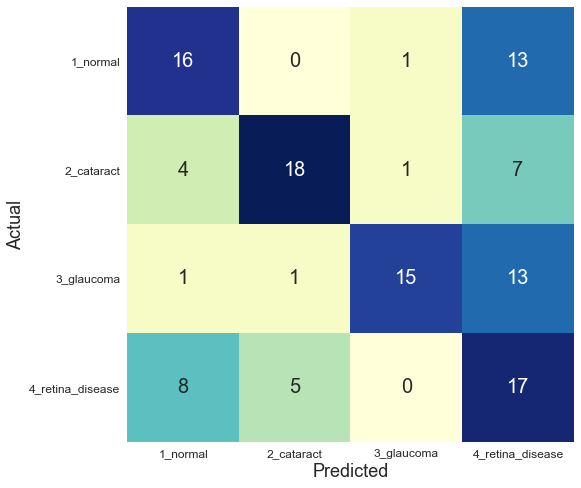

Confusion Matrix for  5 Cross Validation Test phase


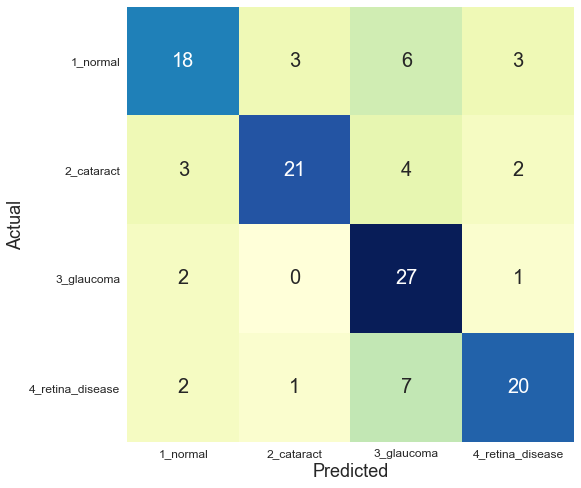

In [38]:
k=1
for i in range(5):    
    print('Confusion Matrix for ',k,'Cross Validation Test phase')
    k +=1
    confusionmatrix_vis(i)
    


# Visualizing Summarized Confusion Matrix of all 5 folds

In [39]:
CM_sum = CM[0]+CM[1]+CM[2]+CM[3]+CM[4]
CM_sum

array([[ 99,   4,  22,  25],
       [ 17, 106,  12,  15],
       [ 21,   6, 101,  22],
       [ 31,  13,  26,  80]], dtype=int64)

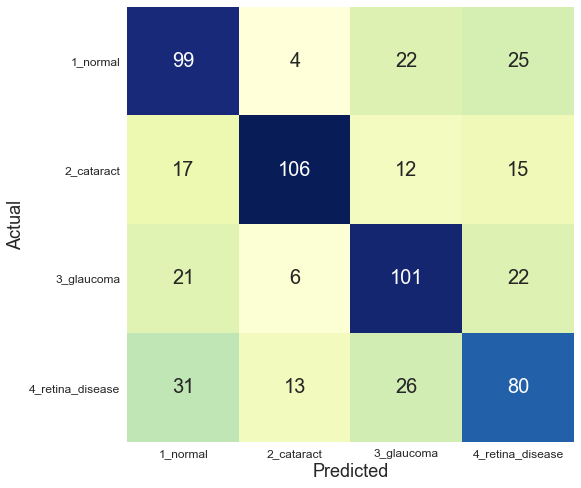

In [40]:
yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
plt.figure(figsize=(8, 8))
hm =sns.heatmap(CM_sum, annot=True,annot_kws={"size": 20},fmt='g', cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

plt.ylabel("Actual", fontsize = 18)
plt.xlabel("Predicted",fontsize = 18)
      
plt.show()

# Reconfirming the values of Accuracy,Sensitivity and Specificity

In [41]:
    sensitivity_1_normal = (CM_sum[0,0])/(CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (CM_sum[1,1])/(CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (CM_sum[2,2])/(CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (CM_sum[3,3])/(CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[1,0]+CM_sum[2,0]+CM_sum[3,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[0,1]+CM_sum[2,1]+CM_sum[3,1]+CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])/(CM_sum[0,2]+CM_sum[1,2]+CM_sum[3,2]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])/(CM_sum[0,3]+CM_sum[1,3]+CM_sum[2,3]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])
    #print('Specificity : ', specificity_4_retina_disease)
    
    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(CM_sum))
    test_accuracy=(CM_sum[0,0]+CM_sum[1,1]+CM_sum[2,2]+CM_sum[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)


Accuracy    :  0.6433333333333333
Specificity :  0.8469702200434992
Sensitivity :  0.6433333333333333


# Model Summary

In [42]:
model_build_compile(k)

model building and compiling for fold 7


In [43]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_388 (BatchN (None, 111, 111, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 111, 111, 32) 0           batch_normalization_388[0][0]    
____________________________________________________________________________________________